# Markov Chain Monte Carlo

Markov Chain Monte Carlo (MCMC) is another class of techniques to perform interence by sampling directly from the posterior distribution. In this tutorial we will showcase how to use [emcee](https://emcee.readthedocs.io/en/stable/), an *ensemble sampler*. Ensemble samplers uses a set of walkers that move around the parameter space generally spending more time in high probablity regions. Several types of moves are implemented in `emcee` and can be mixed together to form a probabilistic mixture, see [emcee moves documentation](https://emcee.readthedocs.io/en/stable/user/moves/). Accepting or rejecting the move is based on the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). 

In [1]:
import ROOT
import os

############## SET ENVIRONMENT VARIABLES ##############
REPO_HOME     = os.environ['REPO_HOME']
import atiSetup
USE_MPI, USE_GPU, RANK_MPI = atiSetup.setup(globals(), use_genamp=True) # RANK_MPI defaults to 0 even if not using MPI

import numpy as np
import emcee
import matplotlib.pyplot as plt
from LoadParameters import LoadParameters
import corner
from mcmc import mcmcManager

from utils import PrintSourceCode

Welcome to JupyROOT 6.28/06
atiSetup| jupyter-noteboo called python3.9

------------------------------------------------
atiSetup| MPI is disabled
atiSetup| GPU is disabled
------------------------------------------------


atiSetup| Loading library libAmpTools.so ..............  ON
atiSetup| Loading library libAmpPlotter.so ............  ON
atiSetup| Loading library libAmpsDataIO.so ............  ON
atiSetup| Loading library libFSRoot.so ................  OFF
atiSetup| Loading library libAmpsGen.so ...............  ON


------------------------------------------------


------------------------------------------------

Initializing AMPTOOLS_AMPS_DATAIO for PyROOT...


Lets start with the general setup first. We first have to define the location of the `AmpTools` configuration file that defines the fit model and datasets. We also need to define some folder names and file names to dump the results to. 

In [2]:
cfgfile = f'{REPO_HOME}/tests/samples/SIMPLE_EXAMPLE/fit.cfg'
overwrite_ofile = True
ofile = 'mcmc/mcmc.h5'
corner_ofile = 'corner.png'

The main components to this algorithm are shown below. We have to define how many walkers, `nwalkers`, we wish to sample the posterior distribution with. 

A `burnIn` phase is typically performed before keeping any accepted samples. Depending on the setup, this phase can remove the dependence on initial conditions and helps ensure that the accepted samples are mixed. 

`nsamples` dictate how many accepted samples we should obtain for each walker.

As we are simplying sampling around a MLE we will ignore *burn in* for now and request a small number of samples for lighter computation and cleaner output.

In [3]:
nwalkers = 32
burnIn = 0
nsamples = 200
overwrite_ofile = True # whether we should always overwrite the output file
seed = 42 # for reproducibility

In [4]:
print("\n ====================================================================================")
print(f" cfgfile: {cfgfile}")
print(f" ofile: {ofile}")
print(f" corner_ofile: {corner_ofile}")
print(f" nwalkers: {nwalkers}")
print(f" burnIn: {burnIn}")
print(f" nsamples: {nsamples}")
print(f" overwrite_ofile: {overwrite_ofile}")
print(f" seed: {seed}")
print(" ====================================================================================\n")


 cfgfile: /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/fit.cfg
 ofile: mcmc/mcmc.h5
 corner_ofile: corner.png
 nwalkers: 32
 burnIn: 0
 nsamples: 200
 overwrite_ofile: True
 seed: 42



We also have to define the *Posterior distribution*. In practice this means we have to define the *likelihood* (which is taken from `AmpTools`) and a *prior* distribution. For now, we will ignore the *prior* and run the `emcee` sampler for the *likelihood* distribution. The definition of the log posterior probability used in this tutorial is shown below. A `mcmcManager` class is used to store the probability distributions' definitions, perform the sampling, and drawing the corner plot. We will initialize this manager in a little bit.

In [5]:
PrintSourceCode(mcmcManager.LogProb)

def LogProb(
        self,
        par_values,
        keys,
        ):
        '''
        Definition of the (Log) Posterior distribution

        Args:
            par_values (MinuitParameter*): list of parameter names and values. Production coeffs are split into (re)al/(im)aginary parts
            keys (str): parameter names
                If multiple config files were passed, the parameter names will be appended with a '_i' tag where i is the ith cfg file

        Returns:
            log_prob (float): Log posterior probability
        '''

        ## Calculate Log likelihood
        log_prob = 0
        n_atis = len( self.atis )
        for i, ati in zip( range(n_atis), self.atis ):
            _par_values = par_values[self.paramPartitions[i]:self.paramPartitions[i+1]]
            _keys = keys[self.paramPartitions[i]:self.paramPartitions[i+1]]
            for name, value in zip(_keys, _par_values):
                # remove tag from name if multiple cfg files were passed
                name = name[ :name.rfind('_') ] if n_atis > 1 else name
                ati.parameterManager()[name] = value

        log_prob += self.Likelihood(ati) + self.Prior(par_values, keys)

        return log_prob

In [6]:
############## PREPARE FOR SAMPLER ##############
assert( os.path.exists(cfgfile) ), 'Config file does not exist at specified path'
if os.path.isfile(f'{ofile}') and overwrite_ofile:
    os.system(f'rm {ofile}')
    print("Overwriting existing output file!")
if '/' in ofile:
    ofolder = ofile[:ofile.rfind("/")]
    os.system(f'mkdir -p {ofolder}')

Overwriting existing output file!


Lets parse the configuration file and display the contents as we had done in the [fit tutorial](https://lan13005.github.io/PyAmpTools/notebooks/mle.html).

In [7]:
############## LOAD CONFIGURATION FILE ##############
parser = ConfigFileParser(cfgfile)
cfgInfo: ConfigurationInfo = parser.getConfigurationInfo()
cfgInfo.display()

############## REGISTER OBJECTS FOR AMPTOOLS ##############
AmpToolsInterface.registerAmplitude( Zlm() )
AmpToolsInterface.registerDataReader( DataReader() )

ati = AmpToolsInterface( cfgInfo )

   |        ^                                                      |
   |       / \             Version:  v0.15.1-5-g4c36-dirty         |
   |      /---\                                                    |
   |     /     \           GDouble:  8 bytes                       |
   |    /       \ MP           MPI:  NO                            |
   |     -------               GPU:  NO                            |
   |        |                                                      |
   |        |              doi.org/10.5281/zenodo.5039377          |
   |        | OOLS                                                 |

[ ConfigurationInfo ]:

	## CONFIGURATION INFO DISPLAY ##
	

[ ReactionInfo ]:

	############################################
	#############   REACTION INFO  #############
	############################################
	      REACTION NAME:  etapi
	      PARTICLE LIST:  4
			1.  Beam
			2.  Proton
			3.  Eta
			4.  Pi0
	        DATA READER:  ROOTDataReader
					/w/halld-scshel

`AmpTools` uses a `ParameterManager` to manage the fit parameters (amplitudes and production coefficients). Production coefficients are complex numbers and optimization is generally performed on *real* numbers. Complex production coefficients have to be flattened first, splitting them up into their real and imaginary parts. The `LoadParameters` class reads in a [FitResults](https://github.com/mashephe/AmpTools/blob/master/AmpTools/IUAmpTools/FitResults.h) file or a [ConfigurationInfo](https://github.com/mashephe/AmpTools/blob/master/AmpTools/IUAmpTools/ConfigurationInfo.h) object and extracts the free parameters. If a FitResults file is given, the MLE values used instead of the values set with the `initialize` keyword in the cfg file. This class can also perform flattening of complex parameters or unflattening to aggregate real/imaginary components again. 

In [8]:
LoadParametersSampler = LoadParameters(cfgInfo)

Input was a ConfigurationInfo object. Take actions accordingly...


We can now run the mcmc sampler. See [perform_mcmc](https://lan13005.github.io/PyAmpTools/api/mcmc.html#mcmc.perform_mcmc) for the API and source code.

In [9]:
############## RUN MCMC ##############
np.random.seed(seed)

atis = [ati] # list of AmpToolsInterface objects to run MCMC on
LoadParametersSamplers = [LoadParametersSampler] # list of LoadParameters objects to run MCMC on

[ ati.parameterManager().setDoCovarianceUpdate(False) for ati in atis ] # No internal Minuit fit = no covariance matrix

mcmcMgr = mcmcManager(atis, LoadParametersSamplers, ofile)

mcmcMgr.perform_mcmc(
    nwalkers = nwalkers,
    burnIn   = burnIn,
    nsamples = nsamples,
    sampler_kwargs = {'progress': False},  # turn off progress bar for cleaner output
)

print(f"Fit time: {mcmcMgr.elapsed_fit_time} seconds")


 ================== PERFORM_MCMC() KWARGS CONFIGURATION ================== 
nwalkers: 32
burnIn: 0
nsamples: 200
params_dict: {}
moves_mixture: [<emcee.moves.stretch.StretchMove object at 0x7fd9bb3f27c0>]
sampler_kwargs: {'progress': False}

 ================== RUNNING MCMC ================== 
Initializing walkers in an N-ball around the MLE estimate


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [15.92587787 16.44973334 17.51905651 16.73390776 15.60765933]



[Sampler complete]

Mean acceptance fraction: 0.564
Autocorrelation time: 16.447 steps
 =================== RESULTS =================== 
MAP Estimates from 6400 samples obtained over 32 walkers:
   Re[resAmp1]          = -140.188
   Re[resAmp2]          = -80.310
   Im[resAmp2]          = 134.706
   Re[resAmp3]          = -193.365
   Im[resAmp3]          = 106.786
Fit time: 9.106326580047607 seconds
Resetting source kin in /w/halld-scshelf2101/lng/WORK/PyAmpTools/tests/samples/SIMPLE_EXAMPLE/samples/data_generated_samples.root


A [corner](https://corner.readthedocs.io/en/latest/) plot shows pair-wise parameter correlations along with the parameter PDFs along the diagonal. Uncertainties can be extracted from the posterior distribution samples. [draw_corner](https://lan13005.github.io/PyAmpTools/api/mcmc.html#mcmc.draw_corner) wraps `corner` for axis formatting and plotting the Maximum a Posterior (MAP) solution (shown as blue lines) and the initial MLE values (shown as green lines).

The configuration file has been seeded with the MLE fit (using the *include* keyword at the bottom of the cfg file pointing to the *seed* file outputted by `fit`). By running the `emcee` sampler this way gives an estimate of the local posterior distribution 

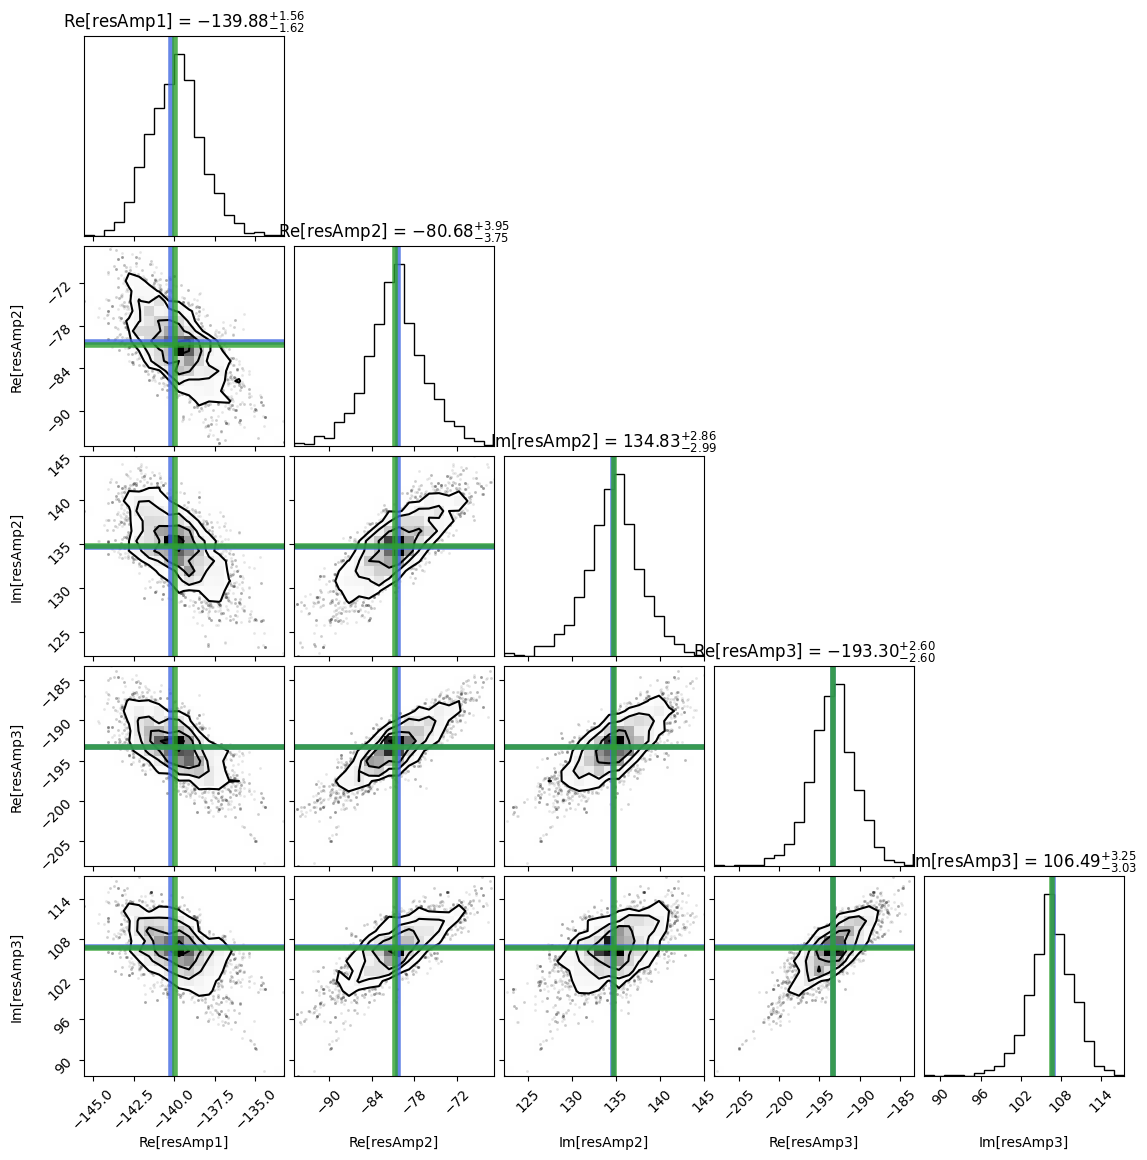

In [10]:
mcmcMgr.draw_corner(f'{ofolder}/{corner_ofile}')

We can see that the parameters are correlated. In this cfg file `resAmp1` is set to be real while `resAmp2` and `resAmp3` are freely floating complex numbers. It can be seen that resAmp1 is negatively correlated with the other parameters. The other parameters are uniformly positively correlated with each other.

# Additional arguments to `perform_mcmc`:
1. `params_dict` - provides ranges or initial values to initialize the walkers with. If you wish to understand the uncertainties around a MLE value, you can pass a dictionary of values: {parameter: value} and the walkers will be initialized around a N-dimensional Gaussian ball around. If you pass a range of values, then the walkers will be uniformly randomized on these intervals. 
2. `move_mixture` - The mixture of moves can have a significant effect on the results. Each move has a set of hyperparameters and an associated probability to be performed. In general, these moves attempt to create a balance between exploring the parameter space and exploiting (or local sampling) regions of high probability.

In [11]:
# Lets perform some cleanup again
!rm -r mcmc